### Exploring Grad-CAM for Mammogram Interpretation
This notebook demonstrates how Grad-CAM (Gradient-weighted Class Activation Mapping) can be used to visualise the regions of a mammogram that contribute to a CNN model's prediction. The model used is MobileNetV3-Small, trained for binary classification of mammograms (benign vs malignant). The notebook walks through loading a model, preparing an image, generating a Grad-CAM heatmap, and overlaying it on the original image.

In [30]:
# imports
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small

import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import PIL

In [31]:
# Grad-CAM hook setup
gradients = None
activations = None

# Function to register Grad-CAM hooks
def register_gradcam_hooks(last_conv_layer):
    """
    Registers forward and backward hooks on the last convolutional layer
    to capture activations and gradients needed for Grad-CAM.
    """
    global gradients, activations

    def forward_hook(module, args, output):
        global activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        global gradients
        gradients = grad_output

    last_conv_layer.register_full_backward_hook(backward_hook, prepend=False)
    last_conv_layer.register_forward_hook(forward_hook, prepend=False)
 

In [32]:
# Function to load model (MobileNetV3 small)
def load_model_mns(model_path):
    """
    Loads MobileNetV3-Small with custom classifier for binary classification,
    and attaches Grad-CAM hooks to its last convolutional layer.
    """
    model = mobilenet_v3_small(weights=None)
    
    # Check the number of input features for the classifier
    num_features = model.classifier[0].in_features

    # Modify the classifier for binary classification
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 1)
    )

    # Load model state
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device("cpu")))

    # Move model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Register Grad-CAM hooks on the last convolutional layer
    last_conv_layer = model.features[-1][0]
    register_gradcam_hooks(last_conv_layer)

    return model

In [33]:
test_transform  = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


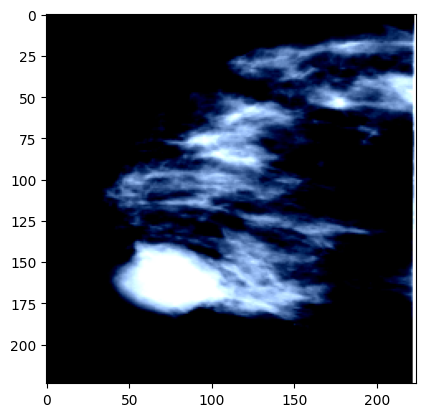

In [34]:
# Load model and image
model_path = "/Users/giulia/Desktop/dissertation-mammogram-classification/mammogram-ai-project/webapp/static/models/best_model_run15.pth"
model = load_model_mns(model_path)

img_path = "/Users/giulia/Desktop/dissertation-mammogram-classification/mammogram-ai-project/Data/Data png cropped/Mass-Test-png-cropped/images/Mass-Test_P_00016_LEFT_CC_FULL.png"
img_path1 = "/Users/giulia/Desktop/dissertation-mammogram-classification/mammogram-ai-project/Data/Data png cropped/Mass-Test-png-cropped/images/Mass-Test_P_00194_RIGHT_CC_FULL.png"

image = Image.open(img_path1).convert('RGB')
img_tensor = test_transform(image)

# SHow input
plt.imshow(img_tensor.permute(1, 2, 0))

In [35]:
# Get prediction
pred = model(img_tensor.unsqueeze(0))
prob = pred.sigmoid()
pred_label = (prob > 0.5).float()
if int(pred_label) == 1:
    confidence = (prob - 0.5) * 200
else:
    confidence = (0.5 - prob) * 200

print(f"Prediction: {'Malignant' if pred_label else 'Benign'}")
print(f"Confidence: {round(float(confidence), 2)}%")

Prediction: Malignant
Confidence: 37.57%


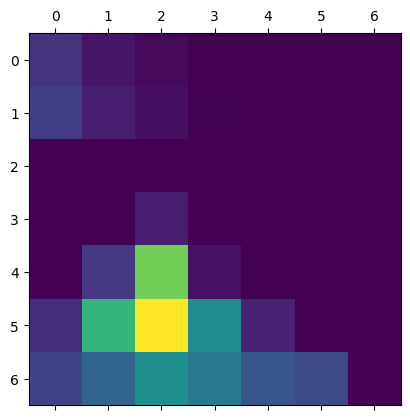

In [36]:
# Generate Grad-CAM heatmap

# Trigger backward pass
model(img_tensor.unsqueeze(0)).backward()

# Compute channel-wise weighted activations
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# Average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# Relu on top of the heatmap
heatmap = F.relu(heatmap)

# Normalise the heatmap
heatmap /= torch.max(heatmap)

# Show the heatmap
plt.matshow(heatmap.detach())

In [37]:
def unnormalise(img_tensor, mean, std):
    """
    Reverses ImageNet normalisation to recover original image values.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

# ImageNet mean/std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

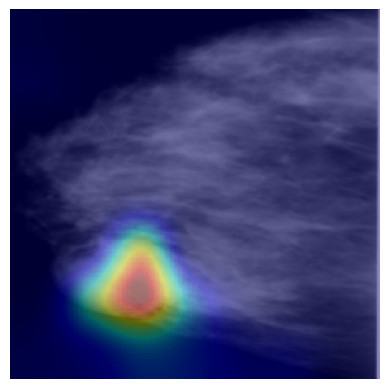

In [38]:
# Create a figure and plot the image
fig, ax = plt.subplots()
ax.axis('off') 

unnorm_img = unnormalise(img_tensor, imagenet_mean, imagenet_std)

# First plot the original image
ax.imshow(to_pil_image(unnorm_img.clamp(0, 1), mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224), resample=PIL.Image.BICUBIC)

# Apply a colormap
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes
ax.imshow(overlay, alpha=0.4, interpolation='nearest')

# Show the plot
plt.show()